Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import dask.dataframe as dd # en caso de tener muchos datos
import locale
import re
locale.setlocale(locale.LC_TIME, "es_ES") 

'es_ES'

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '2022_emt_evolucion.ipynb',
 'datos',
 'gfts.ipynb',
 'gfts_datos',
 'images',
 'README.md']

In [3]:
files = glob.glob("datos/*/*.csv")
# print(files)
# files = glob.glob("*/*Enero-Junio_*.csv")
files

['datos\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Enero-Junio_2019.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2019.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Enero-Junio_2020.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2020.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Enero-Junio_2021.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2021.csv']

In [4]:
# Read column names from file
cols = list(pd.read_csv(files[0], sep=';',nrows=1))
cols = list(filter(lambda col: col.strip(), cols))


#Cargamos los datos y especificamos los tipos en las columnas, así como eliminar la última columna por ser vacia
dfs = [pd.read_csv(f, header=0, sep=";",encoding = "ISO-8859-1",dtype={'Elinea':'str'},usecols=cols) for f in files]
df = pd.concat(dfs,ignore_index=True)


# Elimnar el último dataframe del último fichero de la memoria
del dfs

In [5]:
df.FServicio = pd.to_datetime(df.FServicio, format='%d/%m/%Y')

tiempos = pd.DataFrame({'FServicio': pd.date_range('2019-01-01', '2021-12-31', freq='D')})
tiempos['fechaCorta'] = tiempos['FServicio'].dt.strftime('%B.%Y')
tiempos

,FServicio,fechaCorta
0,2019-01-01,enero.2019
1,2019-01-02,enero.2019
2,2019-01-03,enero.2019
3,2019-01-04,enero.2019
4,2019-01-05,enero.2019
...,...,...
1091,2021-12-27,diciembre.2021
1092,2021-12-28,diciembre.2021
1093,2021-12-29,diciembre.2021
1094,2021-12-30,diciembre.2021


In [6]:
df = df.join(tiempos.set_index('FServicio'),on='FServicio')

In [7]:
# cabeceras = df.loc[:,['CLinea','Elinea','Denominacion']].drop_duplicates().reset_index(drop=True)
# cabeceras[cabeceras['Elinea']!='SE']
# df.sort_values(by=['CLinea','FServicio','IDFranja'])
# df['year'] = df['FServicio'].dt.year
# df['month'] = df['FServicio'].dt.month

In [8]:
# Completamos con 0 las franjas horarias que esten a nulo.
df['Coches'] = df['Coches'].fillna(0)

# Añadimos si ese día era L-V o S-D
df['Diario'] = True
df.loc[df['FServicio'].dt.dayofweek > 4,'Diario'] = False

In [9]:
df['avg_coches'] = df.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')
# https://stackoverflow.com/questions/38869778/pandas-set-column-equal-to-grouped-sum-of-another-column?noredirect=1&lq=1


In [10]:
df[\
    (df['IDFranja']=='H07')\
    &(df['CLinea']==1)\
    &(df['FServicio'].dt.year==2019)\
    &(df['FServicio'].dt.month==1)\
    ].head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,enero.2019,True,5.580645
19,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-02,H07,070000 - 075959,6.0,enero.2019,True,5.580645
38,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-03,H07,070000 - 075959,6.0,enero.2019,True,5.580645
57,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-04,H07,070000 - 075959,6.0,enero.2019,True,5.580645
76,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-05,H07,070000 - 075959,3.0,enero.2019,False,5.580645


In [11]:
# De esta forma pierdo las columnas de 'Denominación' etc. 
# medias_buses = df.groupby(['CLinea','year','month','IDFranja'],as_index=False).mean() 

# En cambio eliminando los duplicados fijándonos por CLinea, FechaCorta e ID Franja mantenemos todas las columnas.
media_buses = df.drop_duplicates(['CLinea','fechaCorta','IDFranja','avg_coches'])

In [12]:
media_buses[(media_buses['IDFranja']=='H07')&(media_buses['CLinea']==25)].head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
79249,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H07,070000 - 075959,3.0,enero.2019,True,10.709677
79859,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-02-01,H07,070000 - 075959,14.0,febrero.2019,True,11.071429
80410,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-03-01,H07,070000 - 075959,14.0,marzo.2019,True,11.000000
81020,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-04-01,H07,070000 - 075959,15.0,abril.2019,True,10.933333
81606,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-05-01,H07,070000 - 075959,4.0,mayo.2019,True,10.838710


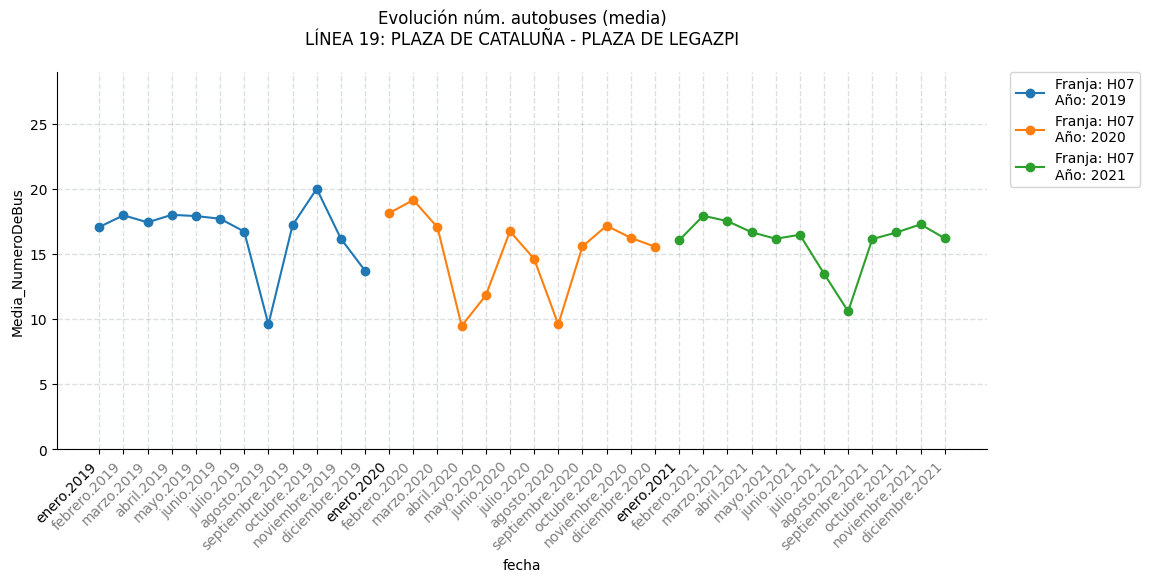

In [13]:
fig, axes = plt.subplots(figsize=(12, 5),dpi=100)
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

num_linea = 19
franja = 'H07'

# Filtro por linea y franja
data = media_buses[(media_buses['IDFranja']==franja)&(media_buses['CLinea']==num_linea)].reset_index(drop=True)
cartel_linea = str(data.loc[0,"Denominacion"])

# Visualizo los datos (avg_coches) y fechas
for fecha in data['FServicio'].dt.year.unique():
    # df.loc[df.index >= N, 'GDP'].plot(color='r', ax=ax)
    axes.plot(data.loc[data['FServicio'].dt.year == fecha,'fechaCorta'],data.loc[data['FServicio'].dt.year == fecha,'avg_coches'],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


# Configuraciones visuales
axes.set_xticks(data['fechaCorta'])
axes.set_xticklabels(data['fechaCorta'], rotation = 45, ha="right",fontdict=dict({'color': 'grey'}))
axes.set_ylim([0,data['Coches'].max()+3])

xTicks = axes.get_xticklabels()
indices_enero = [i for i, item in enumerate(data.fechaCorta) if re.search('enero', item)]
for indeceEnero in indices_enero:
    xTicks[indeceEnero].set_color('black')
    # axes.vlines(x=indeceEnero,ymin=0,ymax=axes.get_yticks().max(),colors='black',linestyles='dashed',)

# Título y nombre ejes
axes.set_xlabel('fecha')
axes.set_ylabel('Media_NumeroDeBus')
axes.set_title(label=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}',pad=20)
# axes.set(
#     xlabel='Mes',
#     ylabel='Media_NumeroDeBus',
#     title=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}'
#     )
axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='both', alpha=0.15)
leg= axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)


plt.draw()

# FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
# p = leg.get_window_extent()
# print(p)
# axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
#             xycoords='figure pixels', zorder=9)


# plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
# plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight', dpi=200)
plt.show()

# Pendiente de hacer
Calcular para cada linea y franja horaria la diferencia de autobuses por mes para cada año 

| Línea |   Fecha    | Diff.AñoAnterior |
|-------|   -------  |------------------|
|   1   | enero.2020 |       10%        |
|   1   | enero.2021 |       -5%        |


#### Duda
Si quisiera mirar la línea que mayor diferencia ha tenido (sin tener en consideración la pandemia) me saldría ordenado por franjas horarias, pero no por linea y franja.

In [14]:
linea25 = media_buses[media_buses['CLinea']==25]

In [15]:
linea25 = linea25[linea25['FServicio'].dt.day==1]
linea25

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
79249,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H07,070000 - 075959,3.0,enero.2019,True,10.709677
79250,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H08,080000 - 085959,3.0,enero.2019,True,12.838710
79251,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H09,090000 - 095959,4.0,enero.2019,True,13.451613
79252,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H10,100000 - 105959,4.0,enero.2019,True,13.064516
79253,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H11,110000 - 115959,4.0,enero.2019,True,10.548387
...,...,...,...,...,...,...,...,...,...,...
3280658,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H20,200000 - 205959,12.0,diciembre.2021,True,9.645161
3280659,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H21,210000 - 215959,9.0,diciembre.2021,True,7.967742
3280660,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H22,220000 - 225959,7.0,diciembre.2021,True,6.633333
3280661,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H23,230000 - 235959,6.0,diciembre.2021,True,5.758621


In [16]:
# media_buses.apply(lambda x: calcularDiferencia(x))

######################
# PENDIENTE DE HACER #
######################

lineas = media_buses['CLinea'].unique()

for linea in lineas:
    linea_df = media_buses[media_buses['CLinea']==linea]
    anios_linea = linea_df['FServicio'].dt.year
    anios_linea = anios_linea.unique()
    franjas_linea = sorted(linea_df['IDFranja'].unique())
    print(anios_linea,franjas_linea,linea)

[2019 2020 2021] ['H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 1
[2019 2020 2021] ['H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 2
[2019 2020 2021] ['H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 3
[2019 2020 2021] ['H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 4
[2019 2020 2021] ['H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 5
[2019 2020 2021] ['H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'M00'] 6
[2019 2020 2021] ['H06', 'H07', 'H08', '

In [17]:
tmp = media_buses.copy()

In [18]:
tmp['mes'] = tmp['FServicio'].dt.month
tmp['year'] = tmp['FServicio'].dt.year

In [19]:
tmp['key_1'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+tmp['year'].astype(str)
tmp['key_2'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-1).astype(str)

In [20]:
tmp2 = tmp.loc[:,['key_1','key_2','CLinea','Coches','FServicio','fechaCorta','IDFranja']]

In [21]:
tmp2

,key_1,key_2,CLinea,Coches,FServicio,fechaCorta,IDFranja
0,001H0712019,001H0712018,1,2.0,2019-01-01,enero.2019,H07
1,001H0812019,001H0812018,1,3.0,2019-01-01,enero.2019,H08
2,001H0912019,001H0912018,1,3.0,2019-01-01,enero.2019,H09
3,001H1012019,001H1012018,1,4.0,2019-01-01,enero.2019,H10
4,001H1112019,001H1112018,1,4.0,2019-01-01,enero.2019,H11
...,...,...,...,...,...,...,...
3865871,781H2082021,781H2082020,781,5.0,2021-08-01,agosto.2021,H20
3865872,781H2182021,781H2182020,781,5.0,2021-08-01,agosto.2021,H21
3865873,781H2282021,781H2282020,781,5.0,2021-08-01,agosto.2021,H22
3865874,781H2382021,781H2382020,781,5.0,2021-08-01,agosto.2021,H23


In [22]:
# https://stackoverflow.com/questions/41511730/python-function-similar-to-vlookup-excel
if 'CochesAnt' in tmp2.columns:
    tmp2.drop(columns=['CochesAnt'],inplace=True)

tmp2.insert(len(tmp2.columns), 'CochesAnt', tmp2['key_2'].map(tmp2.set_index('key_1')['Coches']))
# tmp2.fillna(0,inplace=True)
tmp2.reset_index(inplace=True,drop=True)

tmp2

,key_1,key_2,CLinea,Coches,FServicio,fechaCorta,IDFranja,CochesAnt
0,001H0712019,001H0712018,1,2.0,2019-01-01,enero.2019,H07,NaN
1,001H0812019,001H0812018,1,3.0,2019-01-01,enero.2019,H08,NaN
2,001H0912019,001H0912018,1,3.0,2019-01-01,enero.2019,H09,NaN
3,001H1012019,001H1012018,1,4.0,2019-01-01,enero.2019,H10,NaN
4,001H1112019,001H1112018,1,4.0,2019-01-01,enero.2019,H11,NaN
...,...,...,...,...,...,...,...,...
136249,781H2082021,781H2082020,781,5.0,2021-08-01,agosto.2021,H20,NaN
136250,781H2182021,781H2182020,781,5.0,2021-08-01,agosto.2021,H21,NaN
136251,781H2282021,781H2282020,781,5.0,2021-08-01,agosto.2021,H22,NaN
136252,781H2382021,781H2382020,781,5.0,2021-08-01,agosto.2021,H23,NaN


In [23]:
tmp2['diff'] = (tmp2['Coches']-tmp2['CochesAnt'])/tmp2['CochesAnt']

In [24]:
tmp3 = tmp2[tmp2['FServicio'].dt.year!=2020].sort_values(by='diff')
tmp3

,key_1,key_2,CLinea,Coches,FServicio,fechaCorta,IDFranja,CochesAnt,diff
92028,019H0742021,019H0742020,19,3.0,2021-04-01,abril.2021,H07,18.0,-0.833333
99997,092H2012021,092H2012020,92,1.0,2021-01-08,enero.2021,H20,6.0,-0.833333
99998,092H2112021,092H2112020,92,1.0,2021-01-08,enero.2021,H21,6.0,-0.833333
109849,403H0742021,403H0742020,403,3.0,2021-04-01,abril.2021,H07,18.0,-0.833333
93090,028H0842021,028H0842020,28,4.0,2021-04-01,abril.2021,H08,23.0,-0.826087
...,...,...,...,...,...,...,...,...,...
136249,781H2082021,781H2082020,781,5.0,2021-08-01,agosto.2021,H20,NaN,NaN
136250,781H2182021,781H2182020,781,5.0,2021-08-01,agosto.2021,H21,NaN,NaN
136251,781H2282021,781H2282020,781,5.0,2021-08-01,agosto.2021,H22,NaN,NaN
136252,781H2382021,781H2382020,781,5.0,2021-08-01,agosto.2021,H23,NaN,NaN


In [25]:
pd.DataFrame(columns=['Linea','Franja','CochesActual','CochesAnt','FechaActual','FechaAnt'])

,Linea,Franja,CochesActual,CochesAnt,FechaActual,FechaAnt


In [26]:
pd.DataFrame(columns=['LineaFranja','CochesActual','CochesAnt','FechaActual','FechaAnt'])

,LineaFranja,CochesActual,CochesAnt,FechaActual,FechaAnt
